# The SARIMA Model

## Table of Contents

1. [Import Libraries](#Import_Libraries)
2. [Setup MLFlow Tracking](#MLFlow_Tracking)
3. [Load Data](#Load_Data)
4. [Pre-Process Data](#Pre_Processing)


5. Product Categories
   
   5.1 [Bed, Bath and Table](#bed_bath_table) 
   
   5.2 [Health and Beauty](#health_beauty)
   
   5.3 [Sports and Leisure](#sports_leisure)
   
   5.4 [Furniture Decor](#furniture_decor)
   
   5.5 [Watches and Gifts](#watches_gifts)
   
   5.6 [Telephony](#telephony)
   
   5.7 [Housewares](#housewares)

# Import Libraries <a name = "Import_Libraries"/>

In [1]:
import sys
import os
from utils import utils, metrics, dataset_2
import json
from pprint import pprint
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')
import seaborn as sns
import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score, median_absolute_error
from math import sqrt

#SARIMA Package
import statsmodels.api as sm

# Utils package to be used in grid search for best result providing parameters of the baseline model
import itertools

# SARIMA produces a warning for each forecast. This is used to prevent printing the warning hundreds of times.
import warnings
warnings.filterwarnings("ignore")

#Performance evaluation metrics
from sklearn.metrics import mean_squared_error

# Used to display a progress bar as the baseline model SARIMA is being run
from tqdm import tqdm

#Track Params, Metrics & Results
import mlflow



C:\Users\feras\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\feras\Anaconda3\lib\site-packages\patsy\constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


# Setup MLFlow Tracking <a name = "MLFlow_Tracking"/>

https://www.mlflow.org/docs/latest/tracking.html

In [2]:
# If this is the first time running the notebook, uncomment next line.
#This is to create a file called mlruns which will store the logs for each time the notebook is run

#mlflow_experiment_id = mlflow.create_experiment('Olist_SARIMA_Historical_MLFlow')

#else:
mlflow.set_experiment('Olist_SARIMA_Historical_MLFlow')
client = mlflow.tracking.MlflowClient()
# See ui 
#!mlflow ui

# Load Data <a name = "Load_Data"/>

In [3]:
# Read Config file
config = "configs_Baselines.json"

try:
    with open(config, "r") as f:
        config = json.load(f)
        print('\033[92m','Load successfull. config = \n')
        pprint(config)
except:
    raise IOError(f"Impossible to read config file: {config}")

 Load successfull. config = 

{'dates': {'test_end': '2017-12-14',
           'test_start': '2017-12-01',
           'train_start': '2017-07-01',
           'valid_start': False},
 'directories': {'base_dir': 'brazilian-ecommerce'},
 'drop_date': False,
 'end_date': '2017-12-31 23:59:59',
 'pre_processing': {'add_date_features': False,
                    'col_name': 'payment_value',
                    'impute_nan': 'zero',
                    'prefix_name': 'lag',
                    'window_size': 0},
 'product_categories': ['bed_bath_table',
                        'health_beauty',
                        'sports_leisure',
                        'furniture_decor',
                        'computer_accessories',
                        'housewares',
                        'watches_gifts',
                        'telephony',
                        'garden_tools',
                        'auto'],
 'rm_product_category': False,
 'start_date': '2016-11-01 00:00:00',
 'state': 'SP',


# Pre-Process Training and Test Datasets <a name = "Pre_Processing"/>

In [4]:
df_train, df_test = dataset_2.make_dataset(config)

In [5]:
df_train = df_train.set_index('order_approved_at') 
df_test = df_test.set_index('order_approved_at')

# Product Category 1: Bed, Bath and Table <a name = "bed_bath_table"/>

In [6]:
#Filter on product category for train/test sets
bed_bath_table_train = df_train.loc[df_train['product_category_name'] == 'bed_bath_table']
bed_bath_table_test = df_test.loc[df_test['product_category_name'] == 'bed_bath_table']

#Remove product cateogry column on filtered sets

bed_bath_table_train = bed_bath_table_train.drop(['product_category_name'], axis=1)
bed_bath_table_test= bed_bath_table_test.drop(['product_category_name'], axis=1)


## Search for Best Parameters

The below code is primarily utilized from the following resource: 

https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

In [7]:
p = d = q = range(0,3)

pdq = list(itertools.product(p, d, q))

#For the seasonal pdq, four different choices for the seasonal components were added without knowing which to use.
#Adding too many values will mean it will take a while to conduct the grid search. 
#In this case, we would need to repeat this process as many times as there are product categories & rolling windows
#It may be that using four seasonal components is too many.
spdq = list(itertools.product(p, d, q, [4,5,6,7]))

In [8]:
# Store results in a dataframe
results_preds = pd.DataFrame()

In [9]:
# Using tqdm, we  wrap the object we are iterating over.

for param in tqdm(pdq):
    for param_seasonal in spdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(bed_bath_table_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_qqstationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            
            # Forecast four days in the future
            pred_uc = results.get_forecast(steps=13)
            
            # Calculate MSE
            mse_result = mean_squared_error(bed_bath_table_test, pred_uc.predicted_mean.values)
            
            # Store configuration and results and then append to the results_preds data frame
            # AIC stands for Akaike information criterion and can be used to estimate the quality of the models
            # We can use both AIC and MSE 
            row = pd.DataFrame({'Model': [str(param)+"x"+str(param_seasonal)],
                                'Aic': [results.aic],
                                'Mse': [mse_result]})
            
            results_preds = results_preds.append(row)
        except:
            continue

100%|██████████| 27/27 [39:17<00:00, 87.31s/it] 


In [10]:
results_preds.dropna().sort_values(by='Mse').head()

,Model,Aic,Mse
0,"(1, 0, 0)x(1, 0, 0, 7)",2325.464578,9526.737819
0,"(0, 0, 2)x(1, 0, 0, 7)",2331.042232,9697.800579
0,"(0, 0, 1)x(1, 0, 0, 7)",2331.123552,10773.305250
0,"(0, 0, 0)x(0, 0, 2, 7)",2353.383174,14304.964319
0,"(2, 0, 0)x(1, 0, 0, 7)",2320.236821,14415.560140


## Log Parameters

In [11]:
# Log parameters for the first and only time
best_params = results_preds.dropna().sort_values(by='Mse').head(1)

with mlflow.start_run() as run:
    mlflow.log_param('Product Category','Bed, Bath and Table')
    mlflow.log_param('SARIMA_Params_Criterion', best_params)                                     
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: dab0a79986cb4489b25f9846f2a77d38


## Train SARIMA Model

In [12]:
# Select the model parameters with the lowest MSE and AIC.

mod1 = sm.tsa.statespace.SARIMAX(bed_bath_table_train,
                                order=(1,0,0),
                                seasonal_order=(1,0,0,7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

# Fit the model
results1 = mod1.fit()

# Generate the forecasts. For this experiment we forecast 13 days into the future
pred_uc1 = results1.get_forecast(steps=13)

## Plot Results

In [13]:
pd.plotting.register_matplotlib_converters() # prevents error

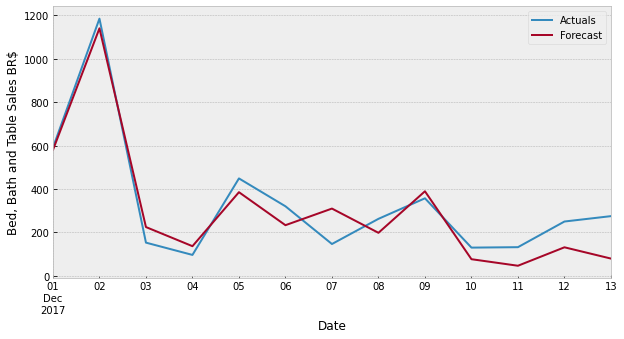

In [14]:
#The StatsModels API returns the index (order_approved_at) as a date object 
#whereas the index in the bed_bath_table dataframe is a string. 
#Therefore to plot the data we convert back to the propper index

actuals = bed_bath_table_test['payment_value'] 

ax = actuals.plot(label='Actuals', figsize=(10, 5))

# There might be negative values in the predictions and therefore pick the maximum value or zero.

np.maximum(pred_uc1.predicted_mean, 0).plot(ax=ax,label='Forecast')

ax.set_xlabel('Date')
ax.set_ylabel('Bed, Bath and Table Sales BR$')
plt.legend()
plt.show()

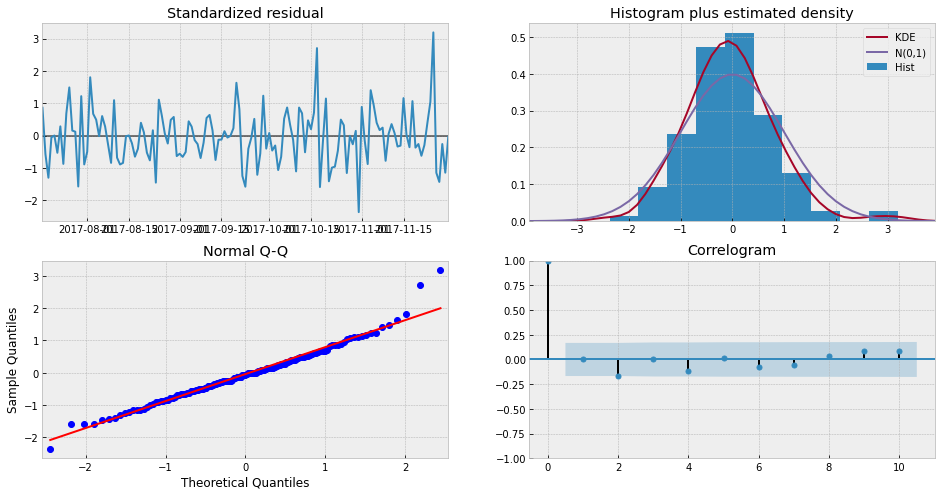

In [15]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Evaluate Performance

In [16]:
metrics.get_metrics(bed_bath_table_test,pred_uc1.predicted_mean, run_id=current_run_id, log=True, param_prefix='test')

wape: 8267.837554382608
rms: 93.95737920022806
r2: 0.8880751275950772
mape: 1.0192986856380022


# Product Category 2: Heath & Beauty <a name = "health_beauty"/>

In [17]:
#Filter on product category for train/test sets
health_beauty_train = df_train.loc[df_train['product_category_name'] == 'health_beauty']
health_beauty_test = df_test.loc[df_test['product_category_name'] == 'health_beauty']

#Remove product cateogry column on filtered sets

health_beauty_train = health_beauty_train.drop(['product_category_name'], axis=1)
health_beauty_test = health_beauty_test.drop(['product_category_name'], axis=1)


## Search for Best Parameters

The below code is primarily utilized from the following resource: 

https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

In [18]:
p = d = q = range(0,3)
pdq = list(itertools.product(p, d, q))

#For the seasonal pdq, four different choices for the seasonal components were added without knowing which to use.
#Adding too many values will mean it will take a while to conduct the grid search. 
#In this case, we would need to repeat this process as many times as there are product categories & rolling windows
#It may be that using four seasonal components is too many.
spdq = list(itertools.product(p, d, q, [4,5,6,7]))

In [19]:
# Store results in a dataframe
results_preds = pd.DataFrame()

In [20]:
# Using tqdm, we  wrap the object we are iterating over.

for param in tqdm(pdq):
    for param_seasonal in spdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(health_beauty_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_qqstationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            
            # Forecast four days in the future
            pred_uc = results.get_forecast(steps=13)
            
            # Calculate MSE
            mse_result = mean_squared_error(health_beauty_test, pred_uc.predicted_mean.values)
            
            # Store configuration and results and then append to the results_preds data frame
            # AIC stands for Akaike information criterion and can be used to estimate the quality of the models
            # We can use both AIC and MSE 
            row = pd.DataFrame({'Model': [str(param)+"x"+str(param_seasonal)],
                                'Aic': [results.aic],
                                'Mse': [mse_result]})
            
            results_preds = results_preds.append(row)
        except:
            continue

100%|██████████| 27/27 [40:26<00:00, 89.88s/it] 


In [21]:
results_preds.dropna().sort_values(by='Mse').head()

,Model,Aic,Mse
0,"(0, 0, 0)x(2, 0, 0, 4)",2371.556757,98678.085039
0,"(2, 0, 0)x(1, 0, 1, 4)",2354.094932,99487.328308
0,"(2, 0, 0)x(0, 1, 1, 4)",2295.777254,101656.858661
0,"(2, 0, 0)x(1, 0, 2, 4)",2355.772341,101664.750731
0,"(2, 0, 0)x(1, 1, 2, 4)",2299.785928,101743.487846


## Log Parameters

In [22]:
# Log parameters for the first and only time
best_params = results_preds.dropna().sort_values(by='Mse').head(1)

with mlflow.start_run() as run:
    mlflow.log_param('Product Category','Health and Beauty')
    mlflow.log_param('SARIMA_Params_Criterion', best_params)                                     
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: a0bdc9eee0bc472fa965c776322ba590


## Train SARIMA Model

In [23]:
# Select the model parameters with the lowest MSE and AIC.

mod1 = sm.tsa.statespace.SARIMAX(health_beauty_train,
                                order=(0,0,0),
                                seasonal_order=(2,0,0,4),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

# Fit the model
results1 = mod1.fit()

# Generate the forecasts. For this experiment we forecast 13 days into the future
pred_uc1 = results1.get_forecast(steps=13)

## Plot Results

In [24]:
pd.plotting.register_matplotlib_converters() # prevents error

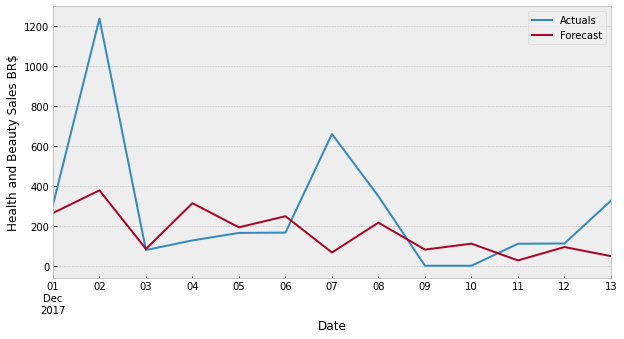

In [25]:
#The StatsModels API returns the index (order_approved_at) as a date object 
#whereas the index in the bed_bath_table dataframe is a string. 
#Therefore to plot the data we convert back to the propper index

actuals = health_beauty_test['payment_value'] 

ax = actuals.plot(label='Actuals', figsize=(10, 5))

# There might be negative values in the predictions and therefore pick the maximum value or zero.

np.maximum(pred_uc1.predicted_mean, 0).plot(ax=ax,label='Forecast')

ax.set_xlabel('Date')
ax.set_ylabel('Health and Beauty Sales BR$')
plt.legend()
plt.show()

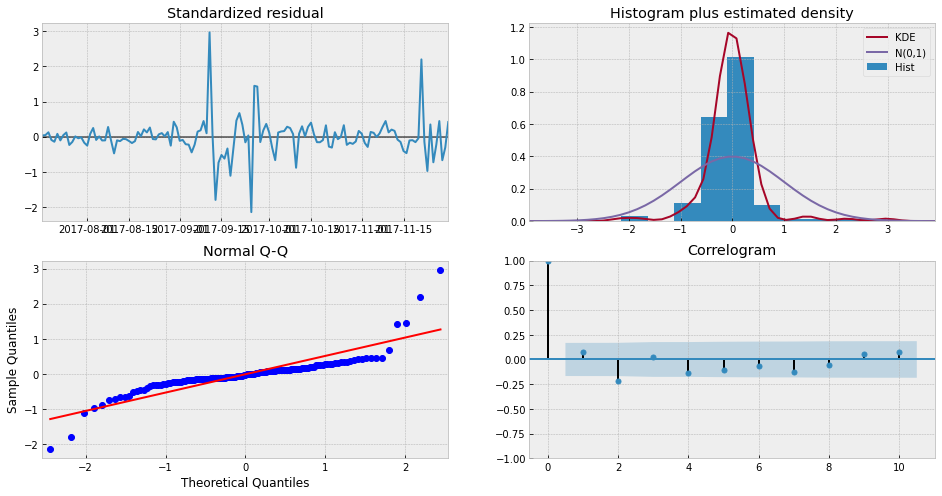

In [26]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Evaluate Performance

In [27]:
metrics.get_metrics(health_beauty_test,pred_uc1.predicted_mean, run_id=current_run_id, log=True, param_prefix='test')

wape: 101546.49175029086
rms: 310.8480269703716
r2: 0.08475798622472186
mape: 25.71815557603123


# Product Category 3: Sports and Leisure <a name = "sports_leisure"/>

In [28]:
#Filter on product category for train/test sets
sports_leisure_train = df_train.loc[df_train['product_category_name'] == 'sports_leisure']
sports_leisure_test = df_test.loc[df_test['product_category_name'] == 'sports_leisure']

#Remove product cateogry column on filtered sets

sports_leisure_train = sports_leisure_train.drop(['product_category_name'], axis=1)
sports_leisure_test = sports_leisure_test.drop(['product_category_name'], axis=1)


## Search for Best Parameters

The below code is primarily utilized from the following resource: 

https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

In [29]:
p = d = q = range(0,3)
pdq = list(itertools.product(p, d, q))

#For the seasonal pdq, four different choices for the seasonal components were added without knowing which to use.
#Adding too many values will mean it will take a while to conduct the grid search. 
#In this case, we would need to repeat this process as many times as there are product categories & rolling windows
#It may be that using four seasonal components is too many.
spdq = list(itertools.product(p, d, q, [4,5,6,7]))

In [30]:
# Store results in a dataframe
results_preds = pd.DataFrame()

In [31]:
# Using tqdm, we  wrap the object we are iterating over.

for param in tqdm(pdq):
    for param_seasonal in spdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(sports_leisure_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_qqstationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            
            # Forecast four days in the future
            pred_uc = results.get_forecast(steps=13)
            
            # Calculate MSE
            mse_result = mean_squared_error(sports_leisure_test, pred_uc.predicted_mean.values)
            
            # Store configuration and results and then append to the results_preds data frame
            # AIC stands for Akaike information criterion and can be used to estimate the quality of the models
            # We can use both AIC and MSE 
            row = pd.DataFrame({'Model': [str(param)+"x"+str(param_seasonal)],
                                'Aic': [results.aic],
                                'Mse': [mse_result]})
            
            results_preds = results_preds.append(row)
        except:
            continue

100%|██████████| 27/27 [35:57<00:00, 79.91s/it] 


In [32]:
results_preds.dropna().sort_values(by='Mse').head()

,Model,Aic,Mse
0,"(2, 0, 2)x(1, 2, 2, 6)",2256.949102,196080.811839
0,"(1, 1, 2)x(2, 2, 2, 6)",2268.079857,202497.043025
0,"(1, 1, 2)x(2, 2, 1, 6)",2263.798432,206890.918119
0,"(2, 2, 2)x(2, 2, 2, 6)",2331.295068,209345.561181
0,"(2, 0, 2)x(2, 2, 1, 6)",2236.306038,216087.261382


## Log Parameters

In [33]:
# Log parameters for the first and only time
best_params = results_preds.dropna().sort_values(by='Mse').head(1)

with mlflow.start_run() as run:
    mlflow.log_param('Product Category','Sports and Leisure')
    mlflow.log_param('SARIMA_Params_Criterion', best_params)                                     
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: e69e99a497a941378f728498e79cbbfc


## Train SARIMA Model

In [34]:
# Select the model parameters with the lowest MSE and AIC.

mod1 = sm.tsa.statespace.SARIMAX(sports_leisure_train,
                                order=(0,0,0),
                                seasonal_order=(2,0,0,4),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

# Fit the model
results1 = mod1.fit()

# Generate the forecasts. For this experiment we forecast 13 days into the future
pred_uc1 = results1.get_forecast(steps=13)

## Plot Results

In [35]:
pd.plotting.register_matplotlib_converters() # prevents error

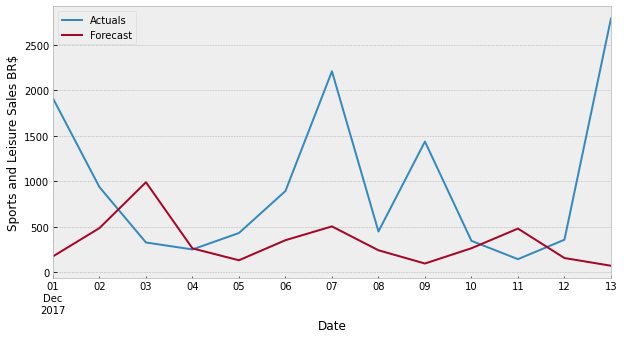

In [36]:
#The StatsModels API returns the index (order_approved_at) as a date object 
#whereas the index in the bed_bath_table dataframe is a string. 
#Therefore to plot the data we convert back to the propper index

actuals = sports_leisure_test['payment_value'] 

ax = actuals.plot(label='Actuals', figsize=(10, 5))

# There might be negative values in the predictions and therefore pick the maximum value or zero.

np.maximum(pred_uc1.predicted_mean, 0).plot(ax=ax,label='Forecast')

ax.set_xlabel('Date')
ax.set_ylabel('Sports and Leisure Sales BR$')
plt.legend()
plt.show()

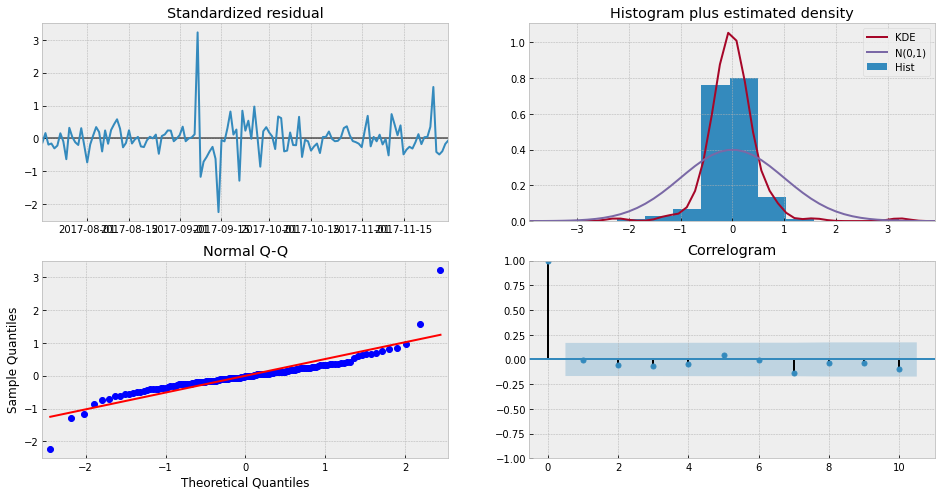

In [37]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Evaluate Performance

In [38]:
metrics.get_metrics(sports_leisure_test,pred_uc1.predicted_mean, run_id=current_run_id, log=True, param_prefix='test')

wape: 1092275.5595278258
rms: 1120.1712006736839
r2: -0.8364896923465241
mape: 0.7197501036606011


# Product Category 4: Furniture Decor <a name = "furniture_decor"/>

In [39]:
#Filter on product category for train/test sets
furniture_decor_train = df_train.loc[df_train['product_category_name'] == 'furniture_decor']
furniture_decor_test = df_test.loc[df_test['product_category_name'] == 'furniture_decor']

#Remove product cateogry column on filtered sets

furniture_decor_train = furniture_decor_train.drop(['product_category_name'], axis=1)
furniture_decor_test = furniture_decor_test.drop(['product_category_name'], axis=1)


## Search for Best Parameters

The below code is primarily utilized from the following resource: 

https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

In [40]:
p = d = q = range(0,3)
pdq = list(itertools.product(p, d, q))

#For the seasonal pdq, four different choices for the seasonal components were added without knowing which to use.
#Adding too many values will mean it will take a while to conduct the grid search. 
#In this case, we would need to repeat this process as many times as there are product categories & rolling windows
#It may be that using four seasonal components is too many.
spdq = list(itertools.product(p, d, q, [4,5,6,7]))

In [41]:
# Store results in a dataframe
results_preds = pd.DataFrame()

In [42]:
# Using tqdm, we  wrap the object we are iterating over.

for param in tqdm(pdq):
    for param_seasonal in spdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(furniture_decor_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_qqstationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            
            # Forecast four days in the future
            pred_uc = results.get_forecast(steps=13)
            
            # Calculate MSE
            mse_result = mean_squared_error(furniture_decor_test, pred_uc.predicted_mean.values)
            
            # Store configuration and results and then append to the results_preds data frame
            # AIC stands for Akaike information criterion and can be used to estimate the quality of the models
            # We can use both AIC and MSE 
            row = pd.DataFrame({'Model': [str(param)+"x"+str(param_seasonal)],
                                'Aic': [results.aic],
                                'Mse': [mse_result]})
            
            results_preds = results_preds.append(row)
        except:
            continue

100%|██████████| 27/27 [34:38<00:00, 76.97s/it] 


In [43]:
results_preds.dropna().sort_values(by='Mse').head()

,Model,Aic,Mse
0,"(1, 1, 0)x(0, 2, 2, 7)",2265.917675,107291.074408
0,"(2, 0, 0)x(0, 1, 1, 7)",2307.662357,138013.275642
0,"(2, 0, 1)x(1, 1, 2, 7)",2313.008213,138903.899804
0,"(0, 0, 2)x(0, 1, 1, 7)",2307.954810,138920.723786
0,"(2, 0, 1)x(0, 1, 1, 7)",2309.914635,140057.220347


## Log Parameters

In [44]:
# Log parameters for the first and only time
best_params = results_preds.dropna().sort_values(by='Mse').head(1)

with mlflow.start_run() as run:
    mlflow.log_param('Product Category','Furniture Decor')
    mlflow.log_param('SARIMA_Params_Criterion', best_params)                                     
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: 77b1a9df7a1a4fa68fa6d5e5d7514141


## Train SARIMA Model

In [45]:
# Select the model parameters with the lowest MSE and AIC.

mod1 = sm.tsa.statespace.SARIMAX(furniture_decor_train,
                                order=(1,1,0),
                                seasonal_order=(0,2,2,7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

# Fit the model
results1 = mod1.fit()

# Generate the forecasts. For this experiment we forecast 13 days into the future
pred_uc1 = results1.get_forecast(steps=13)

## Plot Results

In [46]:
pd.plotting.register_matplotlib_converters() # prevents error

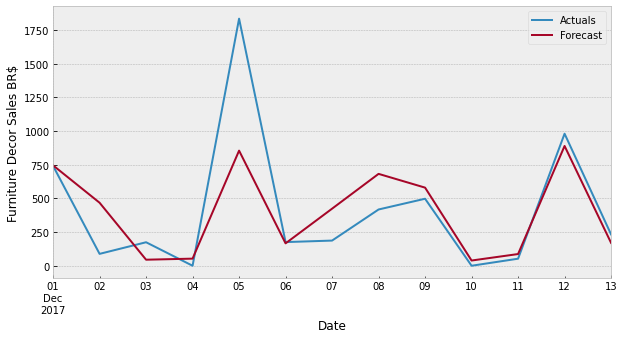

In [47]:
#The StatsModels API returns the index (order_approved_at) as a date object 
#whereas the index in the bed_bath_table dataframe is a string. 
#Therefore to plot the data we convert back to the propper index

actuals = furniture_decor_test['payment_value'] 

ax = actuals.plot(label='Actuals', figsize=(10, 5))

# There might be negative values in the predictions and therefore pick the maximum value or zero.

np.maximum(pred_uc1.predicted_mean, 0).plot(ax=ax,label='Forecast')

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Decor Sales BR$')
plt.legend()
plt.show()

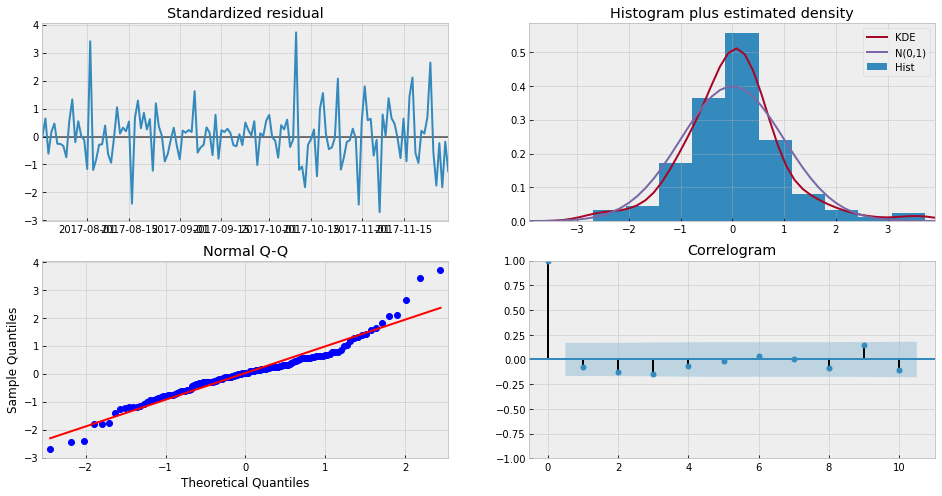

In [48]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Evaluate Performance

In [49]:
metrics.get_metrics(furniture_decor_test,pred_uc1.predicted_mean, run_id=current_run_id, log=True, param_prefix='test')

wape: 145847.67089024233
rms: 312.9114206673035
r2: 0.6064014476147146
mape: 63.10711069561247


# Product Category 5: Watches Gifts <a name = "watches_gifts"/>

In [50]:
#Filter on product category for train/test sets
watches_gifts_train = df_train.loc[df_train['product_category_name'] == 'watches_gifts']
watches_gifts_test = df_test.loc[df_test['product_category_name'] == 'watches_gifts']

#Remove product cateogry column on filtered sets

watches_gifts_train = watches_gifts_train.drop(['product_category_name'], axis=1)
watches_gifts_test = watches_gifts_test.drop(['product_category_name'], axis=1)


## Search for Best Parameters

The below code is primarily utilized from the following resource: 

https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

In [51]:
p = d = q = range(0,3)
pdq = list(itertools.product(p, d, q))

#For the seasonal pdq, four different choices for the seasonal components were added without knowing which to use.
#Adding too many values will mean it will take a while to conduct the grid search. 
#In this case, we would need to repeat this process as many times as there are product categories & rolling windows
#It may be that using four seasonal components is too many.
spdq = list(itertools.product(p, d, q, [4,5,6,7]))

In [52]:
# Store results in a dataframe
results_preds = pd.DataFrame()

In [53]:
# Using tqdm, we  wrap the object we are iterating over.

for param in tqdm(pdq):
    for param_seasonal in spdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(watches_gifts_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_qqstationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            
            # Forecast four days in the future
            pred_uc = results.get_forecast(steps=13)
            
            # Calculate MSE
            mse_result = mean_squared_error(watches_gifts_test, pred_uc.predicted_mean.values)
            
            # Store configuration and results and then append to the results_preds data frame
            # AIC stands for Akaike information criterion and can be used to estimate the quality of the models
            # We can use both AIC and MSE 
            row = pd.DataFrame({'Model': [str(param)+"x"+str(param_seasonal)],
                                'Aic': [results.aic],
                                'Mse': [mse_result]})
            
            results_preds = results_preds.append(row)
        except:
            continue

100%|██████████| 27/27 [34:26<00:00, 76.55s/it] 


In [54]:
results_preds.dropna().sort_values(by='Mse').head()

,Model,Aic,Mse
0,"(2, 0, 1)x(1, 1, 0, 4)",2303.263229,58845.085945
0,"(1, 0, 2)x(1, 1, 0, 4)",2303.407008,59809.891508
0,"(0, 0, 0)x(0, 1, 1, 7)",2221.482613,60522.513833
0,"(0, 0, 1)x(0, 1, 1, 7)",2223.466333,60654.186921
0,"(1, 0, 0)x(0, 1, 1, 7)",2223.461431,60698.528376


## Log Parameters

In [55]:
# Log parameters for the first and only time
best_params = results_preds.dropna().sort_values(by='Mse').head(1)

with mlflow.start_run() as run:
    mlflow.log_param('Product Category','Watches and Gifts')
    mlflow.log_param('SARIMA_Params_Criterion', best_params)                                     
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: f243217c9e2a4fa795d9c17d510a1317


## Train SARIMA Model

In [56]:
# Select the model parameters with the lowest MSE and AIC.

mod1 = sm.tsa.statespace.SARIMAX(watches_gifts_train,
                                order=(2,0,1),
                                seasonal_order=(1,1,0,4),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

# Fit the model
results1 = mod1.fit()

# Generate the forecasts. For this experiment we forecast 13 days into the future
pred_uc1 = results1.get_forecast(steps=13)

## Plot Results

In [57]:
pd.plotting.register_matplotlib_converters() # prevents error

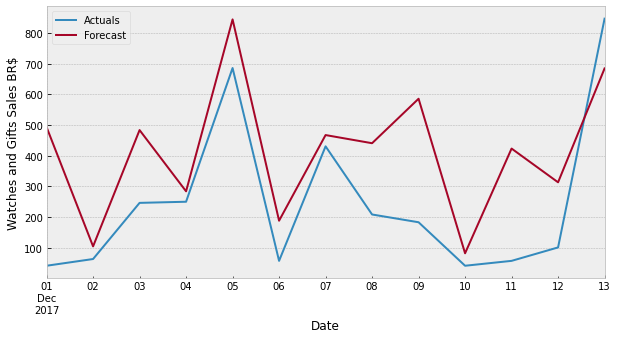

In [58]:
#The StatsModels API returns the index (order_approved_at) as a date object 
#whereas the index in the bed_bath_table dataframe is a string. 
#Therefore to plot the data we convert back to the propper index

actuals = watches_gifts_test['payment_value'] 

ax = actuals.plot(label='Actuals', figsize=(10, 5))

# There might be negative values in the predictions and therefore pick the maximum value or zero.

np.maximum(pred_uc1.predicted_mean, 0).plot(ax=ax,label='Forecast')

ax.set_xlabel('Date')
ax.set_ylabel('Watches and Gifts Sales BR$')
plt.legend()
plt.show()

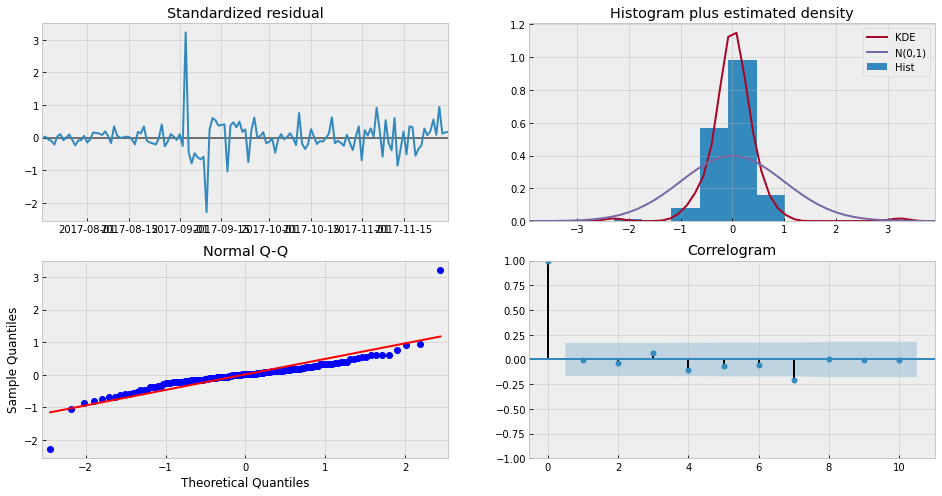

In [59]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Evaluate Performance

In [60]:
metrics.get_metrics(watches_gifts_test,pred_uc1.predicted_mean, run_id=current_run_id, log=True, param_prefix='test')

wape: 22100.517808573848
rms: 237.10989649407082
r2: 0.09113044717254115
mape: 3.431265419317262


# Product Category 6: Telephony <a name = "telephony"/>

In [61]:
#Filter on product category for train/test sets
telephony_train = df_train.loc[df_train['product_category_name'] == 'telephony']
telephony_test = df_test.loc[df_test['product_category_name'] == 'telephony']

#Remove product cateogry column on filtered sets

telephony_train = telephony_train.drop(['product_category_name'], axis=1)
telephony_test = telephony_test.drop(['product_category_name'], axis=1)


## Search for Best Parameters
The below code is primarily utilized from the following resource:

https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

In [62]:
p = d = q = range(0,3)
pdq = list(itertools.product(p, d, q))

#For the seasonal pdq, four different choices for the seasonal components were added without knowing which to use.
#Adding too many values will mean it will take a while to conduct the grid search. 
#In this case, we would need to repeat this process as many times as there are product categories & rolling windows
#It may be that using four seasonal components is too many.
spdq = list(itertools.product(p, d, q, [4,5,6,7]))

In [63]:
# Store results in a dataframe
results_preds = pd.DataFrame()

In [64]:
# Using tqdm, we  wrap the object we are iterating over.

for param in tqdm(pdq):
    for param_seasonal in spdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(telephony_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_qqstationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            
            # Forecast four days in the future
            pred_uc = results.get_forecast(steps=13)
            
            # Calculate MSE
            mse_result = mean_squared_error(telephony_test, pred_uc.predicted_mean.values)
            
            # Store configuration and results and then append to the results_preds data frame
            # AIC stands for Akaike information criterion and can be used to estimate the quality of the models
            # We can use both AIC and MSE 
            row = pd.DataFrame({'Model': [str(param)+"x"+str(param_seasonal)],
                                'Aic': [results.aic],
                                'Mse': [mse_result]})
            
            results_preds = results_preds.append(row)
        except:
            continue

100%|██████████| 27/27 [33:41<00:00, 74.86s/it] 


In [65]:
results_preds.dropna().sort_values(by='Mse').head()

,Model,Aic,Mse
0,"(1, 1, 0)x(1, 2, 2, 6)",1940.034668,25296.358384
0,"(2, 1, 1)x(1, 2, 2, 6)",1942.675479,25550.021703
0,"(1, 1, 0)x(0, 2, 2, 6)",1938.491847,25790.969708
0,"(1, 2, 1)x(1, 2, 2, 6)",1937.563834,26484.515726
0,"(2, 0, 1)x(1, 2, 2, 6)",1892.977334,26936.194049


## Log Parameters

In [66]:
# Log parameters for the first and only time
best_params = results_preds.dropna().sort_values(by='Mse').head(1)

with mlflow.start_run() as run:
    mlflow.log_param('Product Category','Telephony')
    mlflow.log_param('SARIMA_Params_Criterion', best_params)                                     
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: 1192a044c9044b80b08f2d4d56a47932


## Train SARIMA Model

In [67]:
# Select the model parameters with the lowest MSE and AIC.

mod1 = sm.tsa.statespace.SARIMAX(telephony_train,
                                order=(1,1,0),
                                seasonal_order=(1,2,2,6),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

# Fit the model
results1 = mod1.fit()

# Generate the forecasts. For this experiment we forecast 13 days into the future
pred_uc1 = results1.get_forecast(steps=13)

## Plot Results

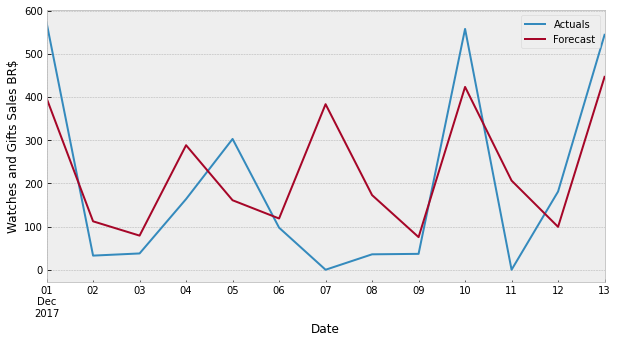

In [68]:
#The StatsModels API returns the index (order_approved_at) as a date object 
#whereas the index in the bed_bath_table dataframe is a string. 
#Therefore to plot the data we convert back to the propper index

actuals = telephony_test['payment_value'] 

ax = actuals.plot(label='Actuals', figsize=(10, 5))

# There might be negative values in the predictions and therefore pick the maximum value or zero.

np.maximum(pred_uc1.predicted_mean, 0).plot(ax=ax,label='Forecast')

ax.set_xlabel('Date')
ax.set_ylabel('Watches and Gifts Sales BR$')
plt.legend()
plt.show()

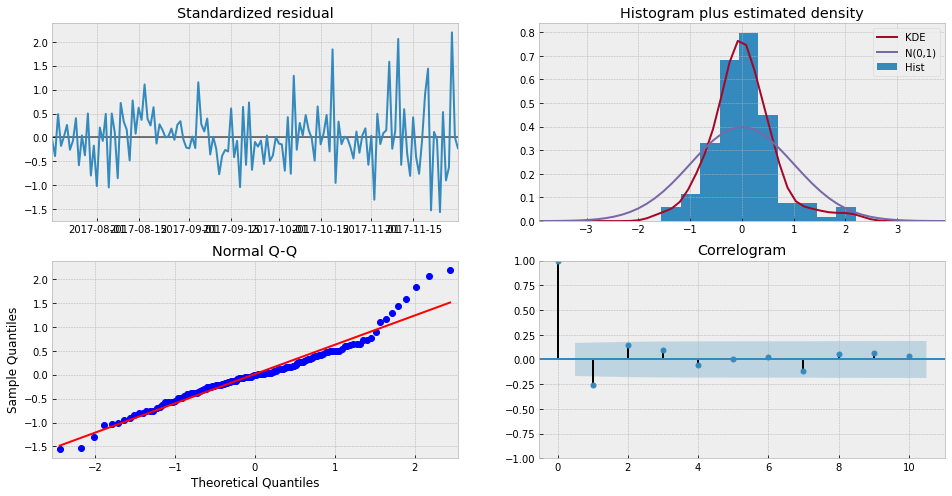

In [69]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Evaluate Performance

In [70]:
metrics.get_metrics(telephony_test,pred_uc1.predicted_mean, run_id=current_run_id, log=True, param_prefix='test')

wape: 19926.81343254722
rms: 156.7938302656941
r2: 0.46446424072067183
mape: 37.111916324601516


# Product Category 7: Housewares <a name = "housewares"/>

In [71]:
#Filter on product category for train/test sets
housewares_train = df_train.loc[df_train['product_category_name'] == 'housewares']
housewares_test = df_test.loc[df_test['product_category_name'] == 'housewares']

#Remove product cateogry column on filtered sets

housewares_train = housewares_train.drop(['product_category_name'], axis=1)
housewares_test = housewares_test.drop(['product_category_name'], axis=1)


## Search for Best Parameters
The below code is primarily utilized from the following resource:

https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

In [72]:
p = d = q = range(0,3)
pdq = list(itertools.product(p, d, q))

#For the seasonal pdq, four different choices for the seasonal components were added without knowing which to use.
#Adding too many values will mean it will take a while to conduct the grid search. 
#In this case, we would need to repeat this process as many times as there are product categories & rolling windows
#It may be that using four seasonal components is too many.
spdq = list(itertools.product(p, d, q, [4,5,6,7]))

In [73]:
# Store results in a dataframe
results_preds = pd.DataFrame()

In [74]:
# Using tqdm, we  wrap the object we are iterating over.

for param in tqdm(pdq):
    for param_seasonal in spdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(housewares_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_qqstationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            
            # Forecast four days in the future
            pred_uc = results.get_forecast(steps=13)
            
            # Calculate MSE
            mse_result = mean_squared_error(housewares_test, pred_uc.predicted_mean.values)
            
            # Store configuration and results and then append to the results_preds data frame
            # AIC stands for Akaike information criterion and can be used to estimate the quality of the models
            # We can use both AIC and MSE 
            row = pd.DataFrame({'Model': [str(param)+"x"+str(param_seasonal)],
                                'Aic': [results.aic],
                                'Mse': [mse_result]})
            
            results_preds = results_preds.append(row)
        except:
            continue

100%|██████████| 27/27 [33:39<00:00, 74.79s/it] 


In [75]:
results_preds.dropna().sort_values(by='Mse').head()

,Model,Aic,Mse
0,"(2, 0, 2)x(2, 2, 2, 4)",2091.449156,118880.770173
0,"(2, 0, 2)x(1, 2, 1, 4)",2057.146409,125048.981874
0,"(1, 2, 2)x(1, 1, 0, 4)",2091.266915,132661.853229
0,"(0, 0, 2)x(2, 2, 2, 4)",2053.775069,138570.384579
0,"(0, 2, 2)x(1, 2, 1, 4)",2064.836928,139608.369158


## Log Parameters

In [76]:
# Log parameters for the first and only time
best_params = results_preds.dropna().sort_values(by='Mse').head(1)

with mlflow.start_run() as run:
    mlflow.log_param('Product Category','Housewares')
    mlflow.log_param('SARIMA_Params_Criterion', best_params)                                     
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: 51c0127a821845f3a0e26889e04ce724


## Train SARIMA Model

In [77]:
# Select the model parameters with the lowest MSE and AIC.

mod1 = sm.tsa.statespace.SARIMAX(housewares_train,
                                order=(2,0,2),
                                seasonal_order=(2,2,2,4),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

# Fit the model
results1 = mod1.fit()

# Generate the forecasts. For this experiment we forecast 13 days into the future
pred_uc1 = results1.get_forecast(steps=13)

## Plot Results

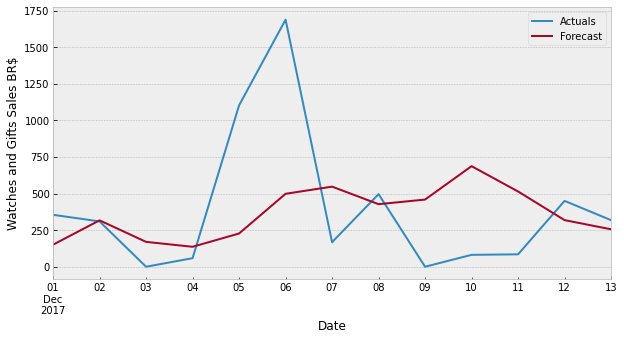

In [78]:
#The StatsModels API returns the index (order_approved_at) as a date object 
#whereas the index in the bed_bath_table dataframe is a string. 
#Therefore to plot the data we convert back to the propper index

actuals = housewares_test['payment_value'] 

ax = actuals.plot(label='Actuals', figsize=(10, 5))

# There might be negative values in the predictions and therefore pick the maximum value or zero.

np.maximum(pred_uc1.predicted_mean, 0).plot(ax=ax,label='Forecast')

ax.set_xlabel('Date')
ax.set_ylabel('Watches and Gifts Sales BR$')
plt.legend()
plt.show()

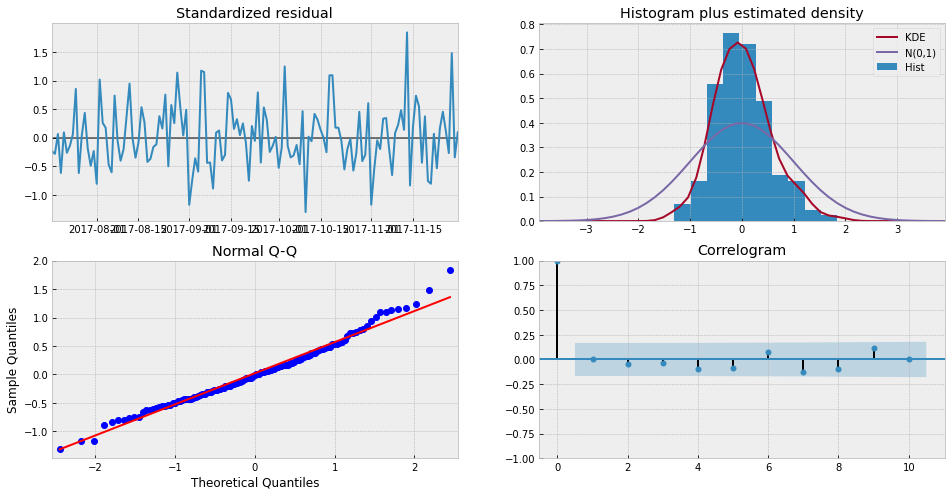

In [79]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Evaluate Performance

In [80]:
metrics.get_metrics(housewares_test,pred_uc1.predicted_mean, run_id=current_run_id, log=True, param_prefix='test')

wape: 207739.27901335942
rms: 495.7452619954444
r2: -0.11078805759119348
mape: 57.03197484126432
